In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from albumentations import (
    Compose, OneOf,
    HorizontalFlip, VerticalFlip, Flip, Rotate,
    Blur, GaussNoise, MedianBlur, MotionBlur, 
    HueSaturationValue, InvertImg, RandomBrightness,
    RandomBrightnessContrast, RandomContrast, RandomGamma,
    RGBShift, ToGray, CLAHE, Transpose, ChannelShuffle

)
from albumentations.pytorch import ToTensor
import cv2
import glob
import numpy as np

from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# Preprocessing class for generate MNIST dataset of digits from 0-100 

In [2]:
class digits(object):
    def __init__(self, train_set):
        self.train_set = train_set
        self.dic = {}
        for i in range(10):
            self.dic[i] = np.where(self.train_set.targets.numpy() == i)[0]
    
    def get_ingredients(self, num):
        '''The function check if number needed to add 
            zeros for get uniform shape of persention '''
        if(num <= 100):
            if num < 10:
                str_num = '00' + str(num)
            if num > 9 and num < 100 :
                str_num = '0' + str(num)
            if num == 100:
                str_num = str(num)
        return [int(d) for d in str_num]


    def generate_full_dictionary(self, amount=1000):
        '''The function generate random numbers from the basic dictionary. 
            For lower computational the function save indexes and won't acutally create images'''
        full_dic={}
        for i in range(101):
            temp = []
            for j in range(amount):
                l = self.get_ingredients(i)
                digit1, digit2, digit3 = l[:3]
                index1 = np.random.choice(self.dic.get(digit1))
                index2 = np.random.choice(self.dic.get(digit2))
                index3 = np.random.choice(self.dic.get(digit3))
                temp.append([index1, index2, index3])

            full_dic[i] = temp

        return full_dic
      
    def generate_image(self, images_indexes_list): 
        '''The function create image'''
        l = [self.train_set.data.numpy()[int(index)] for index in images_indexes_list ]
        return cv2.hconcat(l)
    
    

# LeNet model class

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(1152, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 101)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x.float())), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        y = F.softmax(x, dim=1).double()
        return y



In [4]:
dataset = torchvision.datasets.MNIST(root='', train=True, download=True)

    _____________
# create_digits_object:
#### create digits object
@ train_set - train dataset of 0-10 MNIST digits

__________________
# generate_image:
#### The function get list of indexes from the original MNIST dataset and return concat image of them

_______________
# set_transforms:
#### add transforms to images

___________
# flatten_dic:
#### digits class generate dictionary of digits,
#### key is index and it has list of images.
#### The function flatten the dictionary to long list

In [5]:

def create_digits_object(train_set):
    return digits(train_set)

def generate_image(images_indexes_list): 
        '''The function create image'''
        l = [dataset.data.numpy()[int(index)] for index in images_indexes_list ]
        return cv2.hconcat(l)

def set_transforms(p=1):
    return Compose([OneOf([
                            Blur(blur_limit=7),
                            GaussNoise(var_limit=(10,50)),
                            MedianBlur(blur_limit=7),
                            MotionBlur(blur_limit=7), 
                    ]),
                    OneOf([
                           InvertImg(),
                           RandomBrightness(limit=1),
                           RandomBrightnessContrast(brightness_limit=1, contrast_limit=1),
                           RandomContrast(limit=1),
                           RandomGamma(gamma_limit=(80, 120))
                    ]),
                    Rotate(
                        limit=(-15, 15),
                        interpolation=cv2.INTER_CUBIC,
                        border_mode=cv2.BORDER_REPLICATE)],
                p=p)
    
def flatten_dic(dic):
    raw_data = []
    y=[]
    for index, imgs_list in dic.items():
        for img in imgs_list:
            raw_data.append(np.asarray(img))
            y.append(index)

    X = np.array(raw_data)
    y = np.array(y)
    classes = list(dic.keys())

    return X, y, classes


In [6]:

def create_dataset(X, y, classes, transforms=None):
    return MNISTDataset(
                        data=X,
                        lables=y,
                        classes=classes,
                        transforms=transforms
                        )

def focal_loss1(input1, target,alpha=1, gamma=2):
    BCE_loss = F.binary_cross_entropy_with_logits(input1, target)
    pt = torch.exp(-BCE_loss)
    return (alpha)* ((1-pt)**gamma)* BCE_loss


def evaluate (y_pred, targets):
    actual  = [torch.argmax(x) for x in targets] 
    prediction  = [torch.argmax(x) for x in y_pred]  
    corrects = 0.0
    for t, y in zip(actual,prediction):
        if t == y:
            corrects += 1.0
    return corrects/ len(actual)



In [7]:

class MNISTDataset(Dataset):
        def __init__(self, data, lables, classes, transforms=None, preprocessing=generate_image):
            super(MNISTDataset, self).__init__()
            self.data = data
            print(len(data))
            self.targets = lables
            self.classes = classes
            self.transform = transforms
            self.preprocessing = preprocessing

        def __getitem__(self, idx):
            img = self.preprocessing(self.data[idx])
            label = self.targets[idx]
            
            if self.transform:
                img = self.transform(image=img)
                img = img['image']
            
            y_one_encode = np.zeros(len(self.classes))
            y_one_encode[label] = 1.
            img = img / 255.0
            
            return img, y_one_encode

        def __len__(self):
            return len(self.data)


In [11]:
digs = create_digits_object(dataset)
dic = digs.generate_full_dictionary()

X, labely, classes = flatten_dic(dic)


X_train, X_test, y_train, y_test = train_test_split(X, labely, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

epochs = 10
BS = 128
MNIST_train_dataset = create_dataset(X_train, y_train, classes, transforms=set_transforms())
train_dataloader = DataLoader(MNIST_train_dataset, batch_size=BS, shuffle=True)

MNIST_validation_dataset = create_dataset(X_val, y_val, classes, transforms=set_transforms())
validation_dataloader = DataLoader(MNIST_validation_dataset, batch_size=BS, shuffle=True)

72720
8080


In [24]:
lenet = LeNet()
lenet.to(device)
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

train_loss_list = []
train_accuracy_list = []
epoch_accuracy = 0
epoch_loss = 0
from tqdm import tqdm
for epoch in range(epochs):
    for i, batch in enumerate(train_dataloader, 0):
        xt , yt = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        output = lenet(xt[:, np.newaxis, :])

        loss = focal_loss1(output, yt)
        loss.backward()
        optimizer.step()

        
        epoch_accuracy += evaluate(output, yt)
        epoch_loss += loss.item()

    accurac_mean = epoch_accuracy / i
    loss_mean = epoch_loss / i

    print('Train performence: [%d, %5d] loss: %f, accuracy= %f' % (epoch, i, loss_mean,\
                                                                   round(int(accurac_mean*100))))

    train_loss_list.append(loss_mean)
    train_accuracy_list.append(accurac_mean)
    epoch_accuracy = 0
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(validation_dataloader, 0):
            xv , yv = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            output = lenet(xv[:, np.newaxis, :])

            loss = focal_loss1(output, yv)
                       
            epoch_accuracy += evaluate(output, yt)
            epoch_loss += loss.item()

        accurac_mean = epoch_accuracy / i
        loss_mean = epoch_loss / i

        print('validation performence: [%d, %5d] loss: %f, accuracy= %f %%\n' % (epoch, i, loss_mean,\
                                                                              round(int(accurac_mean*100))))
        epoch_accuracy = 0
        epoch_loss = 0
        



Train performence: [0,   568] loss: 0.175732, accuracy= 20.000000
validation performence: [0,    63] loss: 0.177241, accuracy= 0.000000 %

Train performence: [1,   568] loss: 0.174337, accuracy= 48.000000
validation performence: [1,    63] loss: 0.176488, accuracy= 1.000000 %

Train performence: [2,   568] loss: 0.173829, accuracy= 57.000000
validation performence: [2,    63] loss: 0.176161, accuracy= 1.000000 %

Train performence: [3,   568] loss: 0.173562, accuracy= 62.000000
validation performence: [3,    63] loss: 0.175910, accuracy= 0.000000 %

Train performence: [4,   568] loss: 0.173365, accuracy= 65.000000
validation performence: [4,    63] loss: 0.175748, accuracy= 0.000000 %

Train performence: [5,   568] loss: 0.173236, accuracy= 67.000000
validation performence: [5,    63] loss: 0.175665, accuracy= 1.000000 %

Train performence: [6,   568] loss: 0.173174, accuracy= 68.000000
validation performence: [6,    63] loss: 0.175612, accuracy= 0.000000 %

Train performence: [7,   56

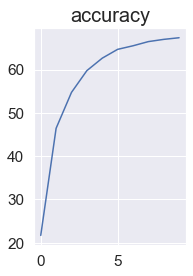

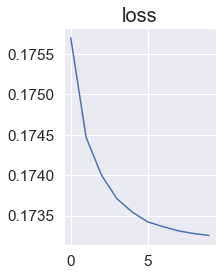

In [23]:
# plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(np.array(train_accuracy_list)*100)
plt.title('accuracy', fontsize=20)
plt.show()

# plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.plot(np.array(train_loss_list))
plt.title('loss', fontsize=20)
plt.show()



In [17]:
from sklearn.metrics import confusion_matrix

_input = torch.from_numpy(np.array([generate_image(x) for x in X_test]))
y_pred = lenet(_input[:,np.newaxis, :, :].to(device))
y_pred =[torch.argmax(x.detach().cpu()) for x in y_pred]
y_pred = torch.stack(y_pred)

cm = confusion_matrix(y_test, y_pred).astype('uint8')

The modle test on: 20200 images, accuracy: 77 %
Examples of 10 correctד examples and 10 wrongs examples


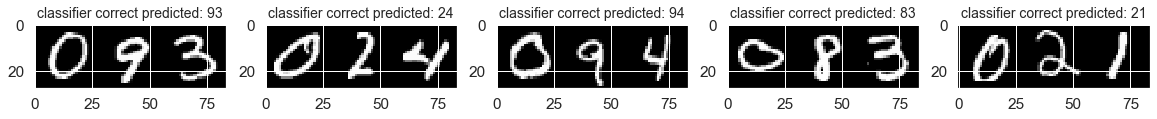

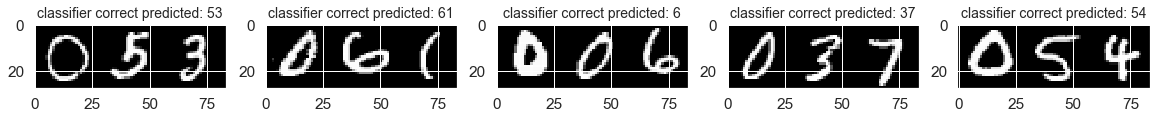

______________________________________________________________________


<Figure size 1440x1440 with 0 Axes>

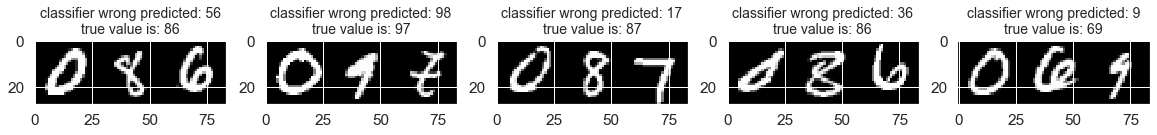

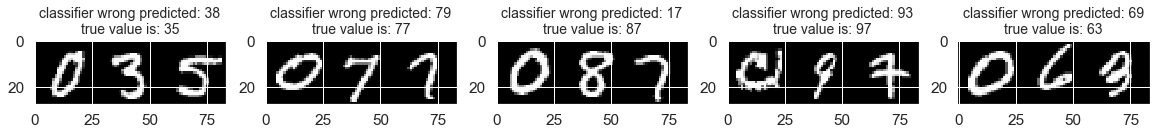

<Figure size 1440x1440 with 0 Axes>

In [22]:
def print_result(classifier, correct=10, wrong=10):
    print(f'Examples of {correct} correctד examples and {wrong} wrongs examples')
    plt.figure(figsize=(20, 20))
    correct_indexes = [np.random.randint(len(classifier['correct'])) for i in range(correct)]
    subplot_index=1
    for index in correct_indexes:
        plt.subplot(1, 5, subplot_index)
        plt.imshow(classifier['correct'][index][1], cmap='gray')
        plt.title(classifier['correct'][index][0], fontsize=14)
        subplot_index+=1

        if subplot_index == 6:
            plt.show()
            plt.figure(figsize=(20, 20))
            subplot_index = 1
    print('_'*70)
    plt.figure(figsize=(20, 20))
    subplot_index = 1
    wrong_indexes = [np.random.randint(len(classifier['wrong'])) for i in range(wrong)]
    for index in wrong_indexes:
        plt.subplot(1, 5, subplot_index)
        plt.imshow(classifier['wrong'][index][1], cmap='gray')
        plt.title(classifier['wrong'][index][0], fontsize=14)
        subplot_index+=1

        if subplot_index == 6:
            plt.show()
            plt.figure(figsize=(20, 20))
            subplot_index = 1



classifier = {
            'correct': [],
            'wrong': []
}

[classifier['correct'].append((f'classifier correct predicted: {pr}', _input[i])) if ac == pr \
else classifier['wrong'].append((f'classifier wrong predicted: {pr}\ntrue value is: {ac}', _input[i])) \
 for i, (ac, pr) in enumerate(zip(y_test, y_pred))]

hit=0
for x,y in zip(y_test, y_pred):
    if x==y:
        hit+=1

print(f'The modle test on: {len(y_test)} images, accuracy: {round((hit/len(y_test)*100))} %')

print_result(classifier)


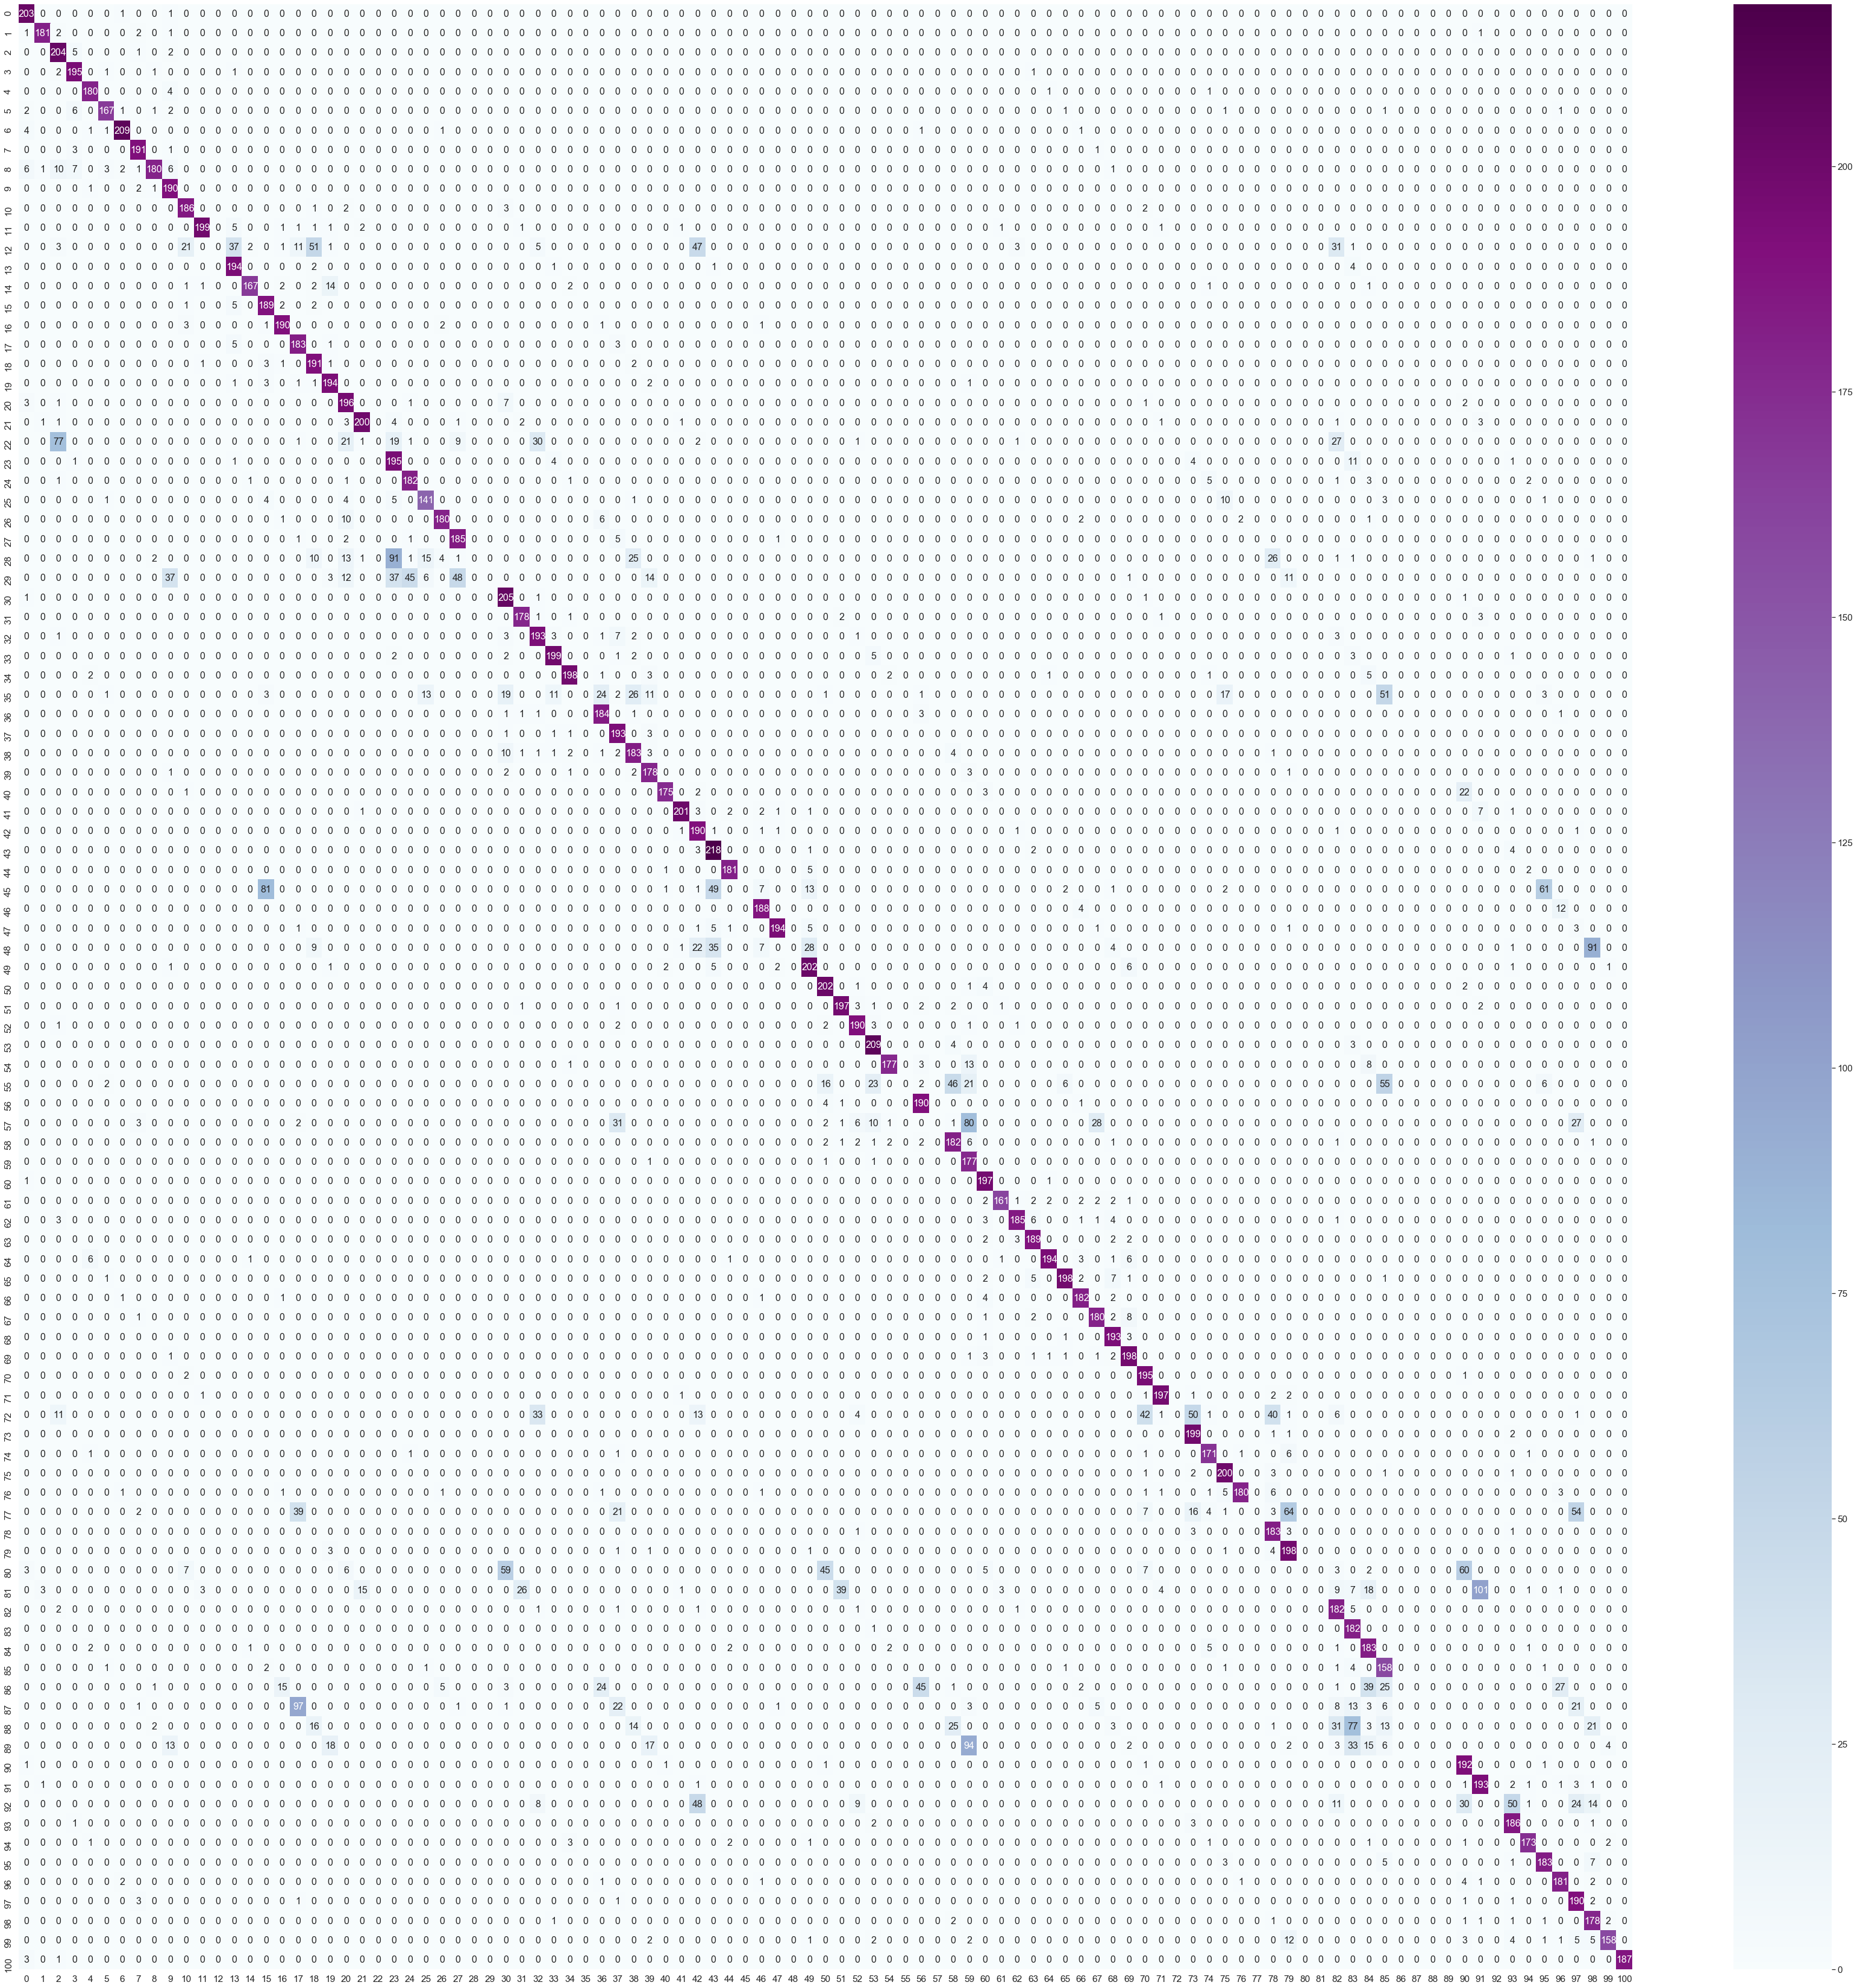

In [19]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, index = [i for i in range(101)],
                  columns = [i for i in range(101)])
plt.figure(figsize = (60,60))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='BuPu',fmt='g'); # font size